In [1]:
#dependencies
from string import punctuation
from os import listdir
from gensim.models import Word2Vec
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow', [dirname(__file__)])
  File "c:\users\mm8355\appdata\local\programs\python\python36-32\lib\imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\tensorflow\python\__init__.py", line 54, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "c:\users\mm8355\appdata\local\programs\python\python36-32\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 20, in swig_import_helper
    import _pywrap_tensorflow
ModuleNotFoundError: No module named '_pywrap_tensorflow'


Error importing tensorflow.  Unless you are using bazel,
you should not try to import tensorflow from its source directory;
please exit the tensorflow source tree, and relaunch your python interpreter
from there.

In [13]:
def load_data(filename,encoding):
    data = pd.read_csv(filename,encoding=encoding)
    return data

def create_train_test_sets(data,split):
    np.random.seed(0)
    mask = np.random.rand(len(data)) < split
    train_data = data[mask]
    test_data = data[~mask]
    return train_data,test_data

def clean_and_get_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [39]:
data = load_data('input.csv','latin1')
words = set()
vocab = {}


token = data['texts'][0].split()
table = str.maketrans('','',punctuation)
tokens = [w.translate(table) for w in token] 
#print(tokens)
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
tokens = [word for word in tokens if len(word)>2]
#print(tokens)

documents = data['texts']
for doc in documents:
    tokens = clean_and_get_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1

for word in vocab:
    if vocab[word] > 2:
        words.add(word)



train_data,test_data = create_train_test_sets(data,0.8)

train_documents = []
for doc in train_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    #final_string = ' '.join(final_tokens)
    train_documents.append(final_tokens)

test_documents = []
for doc in test_data['texts']:
    tokens = doc.split()
    final_tokens = []
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    #final_string = ' '.join(final_tokens)
    test_documents.append(final_tokens)


In [40]:
model = Word2Vec(train_documents, size = 100, window = 5, min_count=1)
words = list(model.wv.vocab)
filename = "embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary=False)

In [41]:
def load_embedding(filename):
    #load embedding into memory
    file = open(filename,'r')
    lines = file.readlines()[1:] #skip first line
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

def get_weight_matrix(embedding, word_indices):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(word_indices)+1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in word_indices.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_documents)
encoded_docs = tokenizer.texts_to_sequences(train_documents)

max_length = max(([len(s) for s in train_documents]))
print(max_length)
train_labels = train_data['CAT']
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(train_labels, num_classes=20)

encoded_docs = tokenizer.texts_to_sequences(test_documents)
test_labels = test_data['CAT']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(test_labels, num_classes=20)

print(max_length)

8
8


In [43]:
vocab_size = len(tokenizer.word_index)+1
raw_embedding = load_embedding('embedding_word2vec.txt')

weight_matrix = zeros((vocab_size, 100))
for word,i in tokenizer.word_index.items():
    if word in raw_embedding:
        weight_matrix[i] = raw_embedding[word]
#print(weight_matrix)
embedding_layer = Embedding(vocab_size, 100, weights=[weight_matrix], input_length=max_length, trainable=True)

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 8, 100)            239000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 32)             25632     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
Total params: 265,292
Trainable params: 265,292
Non-trainable params: 0
_________________________________________________________________
None

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=15, verbose=2, validation_data = (Xtest,ytest))

Train on 5242 samples, validate on 1278 samples
Epoch 1/15
 - 1s - loss: 2.8975 - acc: 0.1043 - val_loss: 2.8104 - val_acc: 0.1479
Epoch 2/15
 - 1s - loss: 2.5134 - acc: 0.2419 - val_loss: 2.4885 - val_acc: 0.2520
Epoch 3/15
 - 0s - loss: 1.8703 - acc: 0.4668 - val_loss: 2.3456 - val_acc: 0.3239
Epoch 4/15
 - 0s - loss: 1.3428 - acc: 0.6204 - val_loss: 2.4007 - val_acc: 0.3482
Epoch 5/15
 - 1s - loss: 0.9831 - acc: 0.7440 - val_loss: 2.5258 - val_acc: 0.3435
Epoch 6/15
 - 1s - loss: 0.7221 - acc: 0.8151 - val_loss: 2.6975 - val_acc: 0.3435
Epoch 7/15
 - 1s - loss: 0.5439 - acc: 0.8646 - val_loss: 2.9468 - val_acc: 0.3357
Epoch 8/15
 - 1s - loss: 0.4197 - acc: 0.9012 - val_loss: 3.1436 - val_acc: 0.3271
Epoch 9/15
 - 0s - loss: 0.3421 - acc: 0.9168 - val_loss: 3.3314 - val_acc: 0.3255
Epoch 10/15
 - 0s - loss: 0.2848 - acc: 0.9285 - val_loss: 3.4917 - val_acc: 0.3279
Epoch 11/15
 - 1s - loss: 0.2360 - acc: 0.9430 - val_loss: 3.6704 - val_acc: 0.3208
Epoch 12/15
 - 1s - loss: 0.2131 - ac

In [40]:
random_text = ["Clinical guidelines managing blood cholesterol"]
encoded_text = tokenizer.texts_to_sequences(random_text)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[1.1583238e-03, 9.5665397e-04, 9.9788505e-01]], dtype=float32)

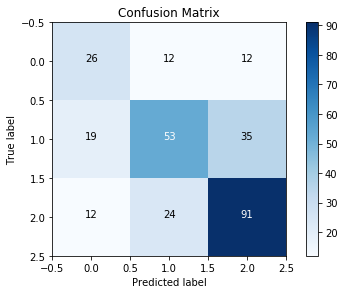

In [41]:
ypred = model.predict(Xtest)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
actual_labels = list(test_labels)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)

import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "Confusion Matrix"
classes = 20
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(5)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()